       AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  \
0       NaN        NaN    483.3133    194.6325        0.9153  304.2065   
1  100409.0   1219.521         NaN    275.7984        0.8077  357.5538   
2   80569.0        NaN    498.0320    212.6353        0.9043  320.2868   
3   58386.0   1088.683    423.7374    187.3131        0.8970  272.6525   
4   84056.0        NaN    464.7390    237.5981        0.8594  327.1443   

   SOLIDITY  CONVEX_AREA  EXTENT  ASPECT_RATIO  ROUNDNESS  COMPACTNESS  \
0    0.9681      75075.0  0.7105        2.4832     0.6052       0.6294   
1    0.9920     101215.0  0.7639        1.6961     0.8484       0.7644   
2    0.9534      84508.0  0.6326        2.3422     0.5832       0.6431   
3    0.9061      64440.0  0.6668        2.2622     0.6190       0.6434   
4    0.9427      89167.0  0.7534        1.9560     0.5506       0.7039   

   SHAPEFACTOR_1  SHAPEFACTOR_2  SHAPEFACTOR_3  SHAPEFACTOR_4  \
0         0.0066         0.0027         0.396

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


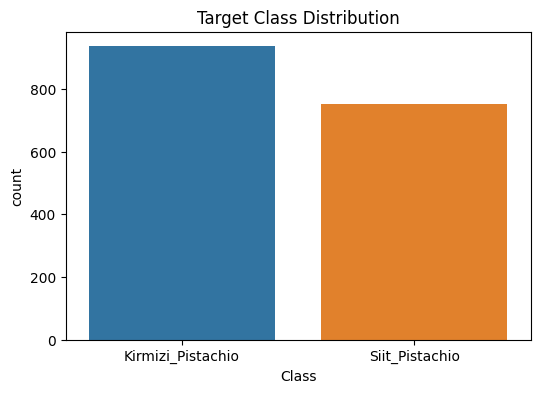

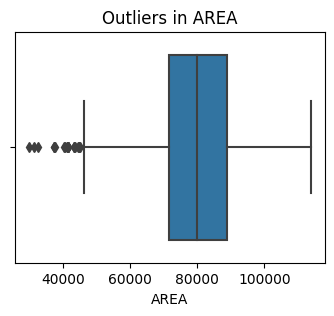

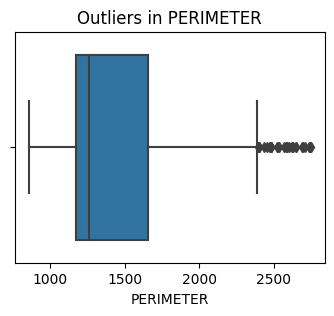

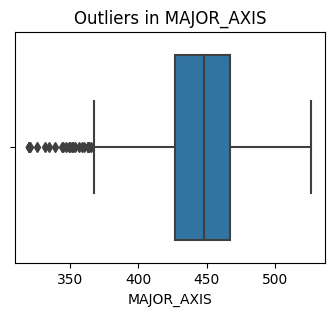

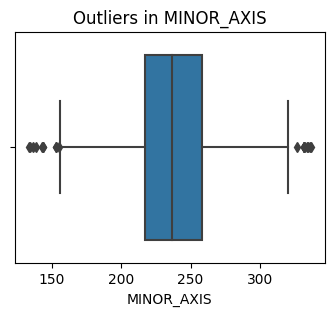

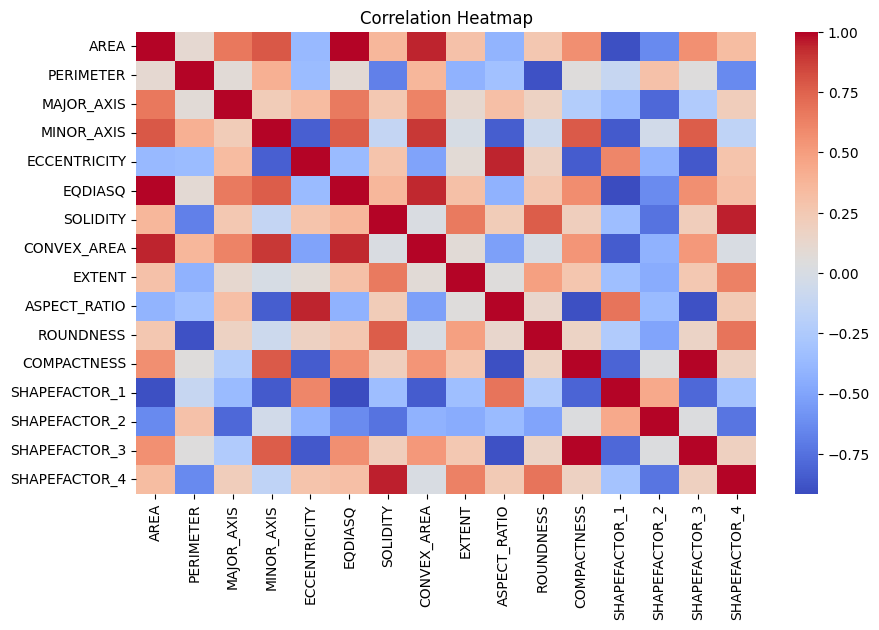

Accuracy: 0.8875739644970414

Classification Report:
                    precision    recall  f1-score   support

Kirmizi_Pistachio       0.89      0.90      0.90       181
   Siit_Pistachio       0.88      0.87      0.88       157

         accuracy                           0.89       338
        macro avg       0.89      0.89      0.89       338
     weighted avg       0.89      0.89      0.89       338



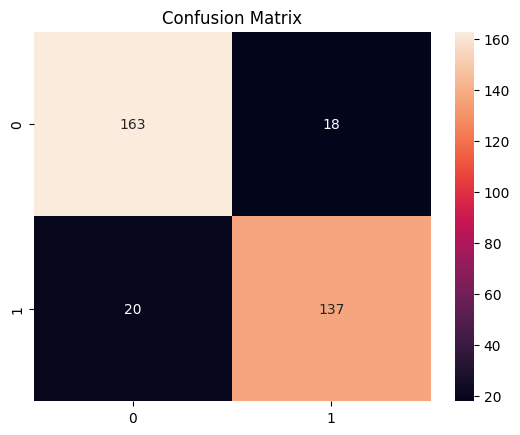

Best Params: {'model__max_depth': None, 'model__n_estimators': 200}
submission.csv generated ✅
   id              Class
0   1  Kirmizi_Pistachio
1   2     Siit_Pistachio
2   3  Kirmizi_Pistachio
3   4  Kirmizi_Pistachio
4   5  Kirmizi_Pistachio


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

TRAIN_PATH = "/kaggle/input/mse-2-ai-201-b-ai-d/train.csv"
TEST_PATH = "/kaggle/input/mse-2-ai-201-b-ai-d/test.csv"

TARGET_COL = "Class"
ID_COL = "id"


train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print(train.head())
print(train.info())
# print("Train shape:", train.shape)
# print("Test shape :", test.shape)


train = train.dropna(subset=[TARGET_COL])

X = train.drop(columns=[TARGET_COL])
y = train[TARGET_COL]



# # Encode target if categorical
# if y.dtype == "object":
#     y = y.astype("category").cat.codes



# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Target Class Distribution")
plt.show()

# Outlier check (numerical)
num_cols = X.select_dtypes(exclude="object").columns

for col in num_cols[:4]:   # only first 4 to avoid clutter
    plt.figure(figsize=(4,3))
    sns.boxplot(x=X[col])
    plt.title(f"Outliers in {col}")
    plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# print("Missing values in target:")
# print(y.isna().sum())

# print("\nTarget value counts (including NaN):")
# print(y.value_counts(dropna=False))


# # Combine X and y first
# train_clean = train.dropna(subset=[TARGET_COL])

# X = train_clean.drop(columns=[TARGET_COL])
# y = train_clean[TARGET_COL]



categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(exclude=["object"]).columns


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)


pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])



X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


pipeline.fit(X_train, y_train)

val_pred = pipeline.predict(X_val)

print("Accuracy:", accuracy_score(y_val, val_pred))
print("\nClassification Report:\n", classification_report(y_val, val_pred))

sns.heatmap(confusion_matrix(y_val, val_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()



param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
pipeline = grid.best_estimator_



pipeline.fit(X, y)


test_predictions = pipeline.predict(test)

submission = pd.DataFrame({
    ID_COL: test[ID_COL] if ID_COL in test.columns else test.index,
    TARGET_COL: test_predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv generated ✅")
print(submission.head())
